In [1]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math

import chess
import chess.svg
import chess.engine
import cairosvg
import io
import matplotlib.pyplot as plt
from PIL import Image
        
engine = chess.engine.SimpleEngine.popen_uci("./engine/stockfish-ubuntu-x86-64")


def display_board(board):
    svg_board = chess.svg.board(board=board)
    png_output = io.BytesIO()
    cairosvg.svg2png(bytestring=svg_board, write_to=png_output)
    img = Image.open(png_output)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()
        

1.26.2
2.0.0+cu117


In [2]:
class AlphaChessHelper:
    ACTION_SIZE = 44672
    def stockfish_play(board):
        result = engine.play(board, chess.engine.Limit(time=0.1))
        return chess.Move.from_uci(str(result.move))
    
    def move_to_integer(move):
        """
        Convert a python-chess Move object (regular or with promotion) to an integer.
        Handles both normal and promotion moves.
        """
        if isinstance(move, int):
            return move
        from_index = move.from_square
        to_index = move.to_square
        
        # Base move: 64 * from_index + to_index
        base_move = 64 * from_index + to_index
        
        if move.promotion:

            # Handle promotion moves: Add extra encoding for promotions
            # Map promotion pieces to integers: Q=0, R=1, B=2, N=3
            promotion_map = {chess.QUEEN: 5, chess.ROOK: 4, chess.BISHOP: 3, chess.KNIGHT: 2}
            return base_move + (move.promotion - 1) * 10000
        else:
            return base_move
        
    def integer_to_move(move_int):
        """
        Convert an integer back to a python-chess Move object (with or without promotion).
        Handles both normal and promotion moves.
        """
        if move_int >= 4096:
            # Handle promotion moves
            promotion = move_int // 10000 + 1
            move_int = move_int % 10000
            from_index = move_int // 64
            to_index = move_int % 64 
            return chess.Move(from_index, to_index, promotion=promotion)
        
        # Handle regular moves
        from_index = move_int // 64
        to_index = move_int % 64
        return chess.Move(from_index, to_index)

    def get_next_state(board, action, move=False):
        if isinstance(action, int):
            action = AlphaChessHelper.integer_to_move(action)
        # get copy instance of board
        if not isinstance(board, chess.Board):
            board = AlphaChessHelper.get_encoded_state_to_board(board)
        board = board.copy()
        board.push(action)
        return board
        

    def get_valid_moves(board):
        return [AlphaChessHelper.move_to_integer(move) for move in list(board.legal_moves)]
    
    def get_valid_moves_bool_array(state):
        if not isinstance(state, chess.Board):
            state = AlphaChessHelper.get_encoded_state_to_board(state)
        valid_moves = AlphaChessHelper.get_valid_moves(state)
        valid_moves_bool_array = np.zeros(AlphaChessHelper.ACTION_SIZE)
        for i, move in enumerate(valid_moves):
            valid_moves_bool_array[move] = 1.0
        return valid_moves_bool_array

    def check_win(board, action):
        if action == None:
            return False
        board.push(action)

        # if is checkmate, return True
        if board.is_checkmate():
            return True
        return  False

    

    def get_value_and_terminated(board, action):
        
        if not isinstance(board, chess.Board):
            board = AlphaChessHelper.get_encoded_state_to_board(board)
        
        copy_board_instance = board.copy()        

        if copy_board_instance.is_game_over():
            if copy_board_instance.is_checkmate():
                return 1, True
            else:
                return 0, True
        return 0, False

    def get_encoded_state_to_board(encoded_state):
        """
        Decodes an encoded state tensor back to a python-chess board object.
        Input tensor shape: (8, 8, 14) where 14 planes represent:
        1-6: White pieces (pawn, knight, bishop, rook, queen, king)
        7-12: Black pieces (pawn, knight, bishop, rook, queen, king)
        13: Castling rights (both white and black combined)
        14: Active player (white or black to move)
        """
        # Initialize an empty board in python-chess
        board = chess.Board(fen=None)  # Empty board
        
        # Map feature plane indices back to piece types
        piece_map = {
            0: chess.PAWN,  # white pawns
            1: chess.KNIGHT,
            2: chess.BISHOP,
            3: chess.ROOK,
            4: chess.QUEEN,
            5: chess.KING,
            6: -chess.PAWN,  # black pawns (negative indicates black)
            7: -chess.KNIGHT,
            8: -chess.BISHOP,
            9: -chess.ROOK,
            10: -chess.QUEEN,
            11: -chess.KING
        }
        
        # Reconstruct piece positions
        for square in chess.SQUARES:
            row, col = divmod(square, 8)
            for plane_index in range(12):  # First 12 planes contain piece info
                if encoded_state[row, col, plane_index] == 1:
                    piece_type = piece_map[plane_index]
                    color = chess.WHITE if plane_index < 6 else chess.BLACK
                    board.set_piece_at(square, chess.Piece(abs(piece_type), color))
        
        # Reconstruct castling rights from plane 12
        castling_rights = int(encoded_state[0, 0, 12])  # Ensure we cast to int
        if castling_rights & 1:  # White kingside
            board.castling_rights |= chess.BB_H1
        if castling_rights & 2:  # White queenside
            board.castling_rights |= chess.BB_A1
        if castling_rights & 4:  # Black kingside
            board.castling_rights |= chess.BB_H8
        if castling_rights & 8:  # Black queenside
            board.castling_rights |= chess.BB_A8
        
        # Set active player from plane 13
        active_player = encoded_state[0, 0, 13]  # Any cell in the 14th plane
        board.turn = chess.WHITE if active_player == 1 else chess.BLACK
        
        # Return the reconstructed board
        return board

    def get_encoded_state(chess_state=None):
        """
        Encodes a python-chess board object into a state tensor for neural network input.
        Output tensor shape: (8, 8, 14) where 14 planes represent the following:
        1-6: White pieces (pawn, knight, bishop, rook, queen, king)
        7-12: Black pieces (pawn, knight, bishop, rook, queen, king)
        13: Castling rights (both white and black combined)
        14: Active player (white or black to move)
        """
        # 8x8 board with 14 feature planes
        state = np.zeros((8, 8, 14), dtype=np.float32)
        
        # Piece type to feature plane mapping for white and black
        piece_map = {
            chess.PAWN: 0,  # white pawns go in plane 0
            chess.KNIGHT: 1,
            chess.BISHOP: 2,
            chess.ROOK: 3,
            chess.QUEEN: 4,
            chess.KING: 5,
            # Black pieces will be shifted by 6 planes
            -chess.PAWN: 6,
            -chess.KNIGHT: 7,
            -chess.BISHOP: 8,
            -chess.ROOK: 9,
            -chess.QUEEN: 10,
            -chess.KING: 11
        }
        
        # Encode piece positions
        for square in chess.SQUARES:
            piece = chess_state.piece_at(square)
            if piece:
                # Get piece type and color
                plane_index = piece_map[piece.piece_type if piece.color == chess.WHITE else -piece.piece_type]
                row, col = divmod(square, 8)
                state[row, col, plane_index] = 1
        
        # Encode castling rights: plane 12
        castling_rights = 0
        if chess_state.has_kingside_castling_rights(chess.WHITE):
            castling_rights |= 1  # White kingside
        if chess_state.has_queenside_castling_rights(chess.WHITE):
            castling_rights |= 2  # White queenside
        if chess_state.has_kingside_castling_rights(chess.BLACK):
            castling_rights |= 4  # Black kingside
        if chess_state.has_queenside_castling_rights(chess.BLACK):
            castling_rights |= 8  # Black queenside
        
        state[:, :, 12] = castling_rights  # Store in the 13th plane
        
        # Encode active player: plane 13
        state[:, :, 13] = 1 if chess_state.turn == chess.WHITE else -1

        return state

    def get_random_prob_action(prob):
        arr = []
        for i, val in enumerate(prob):
            if int(val) != 0:
                print(f"found {val}")
                arr.append(i)
        return np.random.choice(arr)

class AlphaChess:
    def __init__(self):
        self.initial_fen = "r7/8/8/8/8/6k1/4r3/7K w - - 0 1"
        self.board = chess.Board(self.initial_fen)
    
    def reset(self, fen=None):
        if fen:
            self.board = chess.Board(fen)
        else:
            self.board = chess.Board(self.initial_fen)

    def __repr__(self):
        return "AlphaChess"

    def get_initial_state(self):
        return self.board.copy()

    def move(self, action):
        if isinstance(action, int):
            action = AlphaChessHelper.integer_to_move(action)
        self.board.push(action)

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self):
        return self.board
    

    

In [3]:

class ResNet(nn.Module):
    def __init__(self, action_size, num_resBlocks, num_hidden, device):
        super().__init__()
        
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(14, num_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)
        

In [4]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.children = []
        self.prior = prior
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + 2 * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = AlphaChessHelper.get_encoded_state(AlphaChessHelper.get_next_state(child_state, action))
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)                
        return child
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state, player):
        root = Node(self.game, self.args, state, visit_count=1)
        if player == 1 and random.randint(0, 3):
            stockfish_move = AlphaChessHelper.move_to_integer(AlphaChessHelper.stockfish_play(AlphaChessHelper.get_encoded_state_to_board(state)))
            action_probs = np.zeros(AlphaChessHelper.ACTION_SIZE)
            stockfish_move_int = AlphaChessHelper.move_to_integer(stockfish_move)
            action_probs[stockfish_move_int] = 1.0  # Assign 100% probability to Stockfish's move
            return action_probs
        if player == -1:
            random_move = random.choice(list(AlphaChessHelper.get_valid_moves(AlphaChessHelper.get_encoded_state_to_board(state))))
            action_probs = np.zeros(AlphaChessHelper.ACTION_SIZE)
            random_move_int = AlphaChessHelper.move_to_integer(random_move)
            action_probs[random_move_int] = 1.0  # Assign 100% probability to Stockfish's move
            return action_probs
        policy, _ = self.model(
            torch.tensor(state, dtype=torch.float32, device=self.model.device).unsqueeze(0).permute(0, 3, 1, 2)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * AlphaChessHelper.ACTION_SIZE)
        
        valid_moves = AlphaChessHelper.get_valid_moves_bool_array(AlphaChessHelper.get_encoded_state_to_board(state))
        policy *= valid_moves
        if np.sum(policy) > 0:
            policy /= np.sum(policy)
        else:
            policy = valid_moves / np.sum(valid_moves)  # Handle case where all moves are invalid
        
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = AlphaChessHelper.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(node.state, dtype=torch.float32, device=self.model.device).unsqueeze(0).permute(0, 3, 1, 2)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = AlphaChessHelper.get_valid_moves_bool_array(node.state)
                policy *= valid_moves
                if np.sum(policy) > 0:
                    policy /= np.sum(policy)
                else:
                    policy = valid_moves / np.sum(valid_moves)  

                #value = value.item()

                node.expand(policy)
           
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(AlphaChessHelper.ACTION_SIZE)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [5]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
        
    def selfPlay(self, learn_fen=None):
        memory = []
        player = 1
        self.game.reset(learn_fen)
        state = self.game.board
        print("self play")
        moves = 20
        while True:
            state = self.game.board.copy()
            neutral_state = AlphaChessHelper.get_encoded_state(state)
            action_probs = self.mcts.search(neutral_state, player)
            memory.append((neutral_state, action_probs, player))
            
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            max_value = max(action_probs)
            action = random.choice([i for i, x in enumerate(action_probs) if x==max_value])
            self.game.move(int(action))
            
            value, is_terminal = AlphaChessHelper.get_value_and_terminated(self.game.board.copy(), action)

            if is_terminal or moves == 0:
                moves -= 1
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    if player == 1:
                        returnMemory.append((
                            hist_neutral_state,
                            hist_action_probs,
                            hist_outcome
                        ))
                if value > 0:
                    print(f"Game Over. {player} won")
                else:
                    print(f"Game Over. Draw")
                display_board(self.game.board)
                return returnMemory
            player = self.game.get_opponent(player)
                
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device).permute(0, 3, 1, 2)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            self.optimizer.step() # change to self.optimizer
    
    def learn(self, learn_fen=None):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay(learn_fen)
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")

AI is thinking...
AI moved d5d4
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . k . .
. . . . . . . .
. . . . . . . .


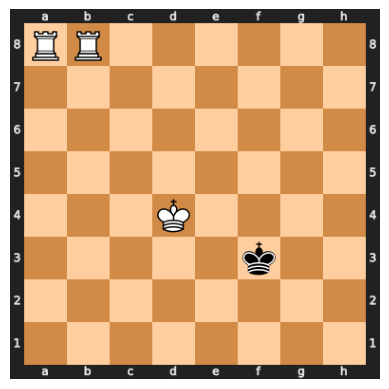

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . k .
. . . . . . . .
. . . . . . . .


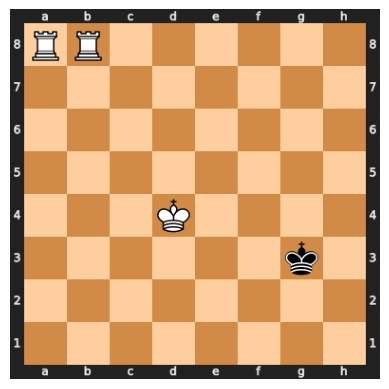

AI is thinking...
AI moved d4e5
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . k .
. . . . . . . .
. . . . . . . .


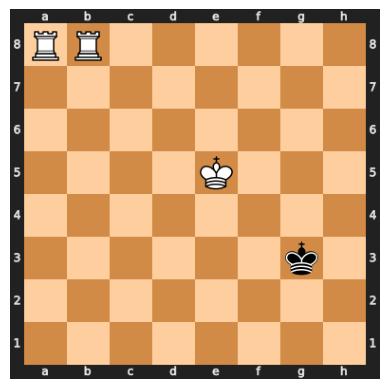

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . . .
. . . . . k . .
. . . . . . . .


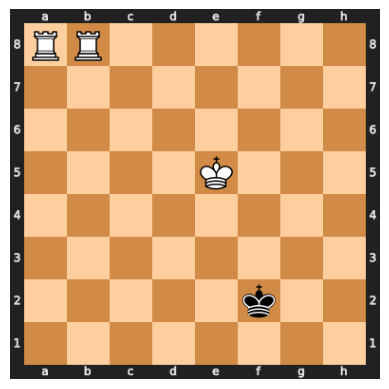

AI is thinking...
AI moved e5f4
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . . k . .
. . . . . . . .


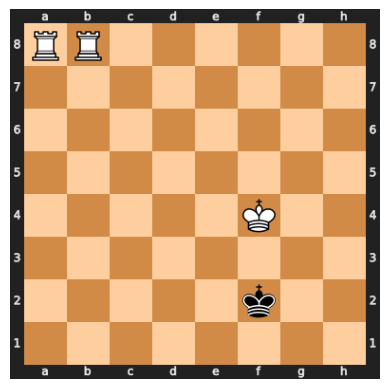

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . k . . .
. . . . . . . .


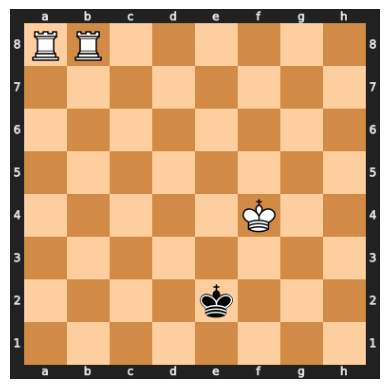

AI is thinking...
AI moved f4e4
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . . . k . . .
. . . . . . . .


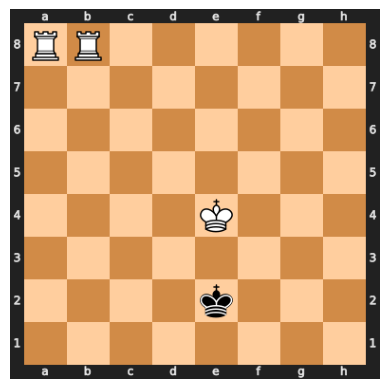

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . . k . . . .
. . . . . . . .


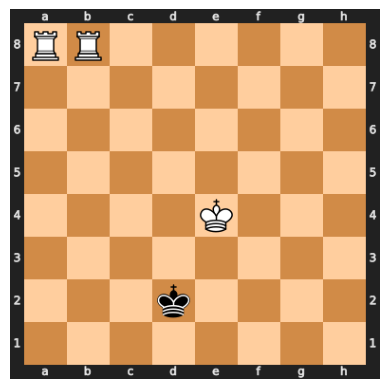

AI is thinking...
AI moved e4e5
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . . .
. . . k . . . .
. . . . . . . .


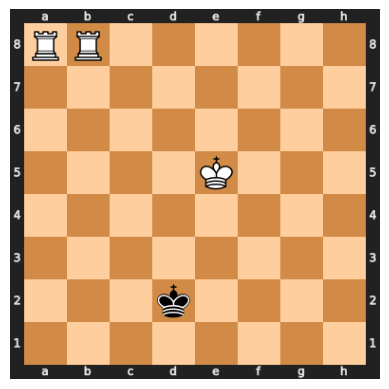

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
. . k . . . . .
. . . . . . . .
. . . . . . . .


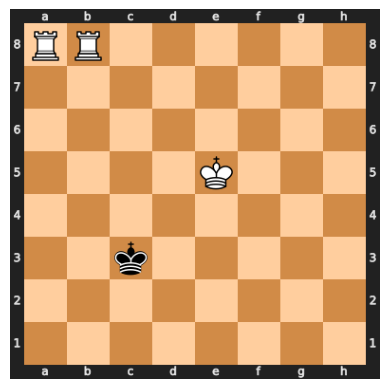

AI is thinking...
AI moved e5f4
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . k . . . . .
. . . . . . . .
. . . . . . . .


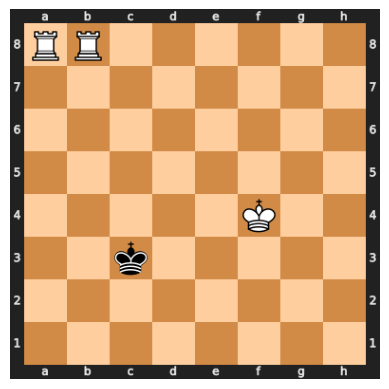

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . . k . . . .
. . . . . . . .
. . . . . . . .


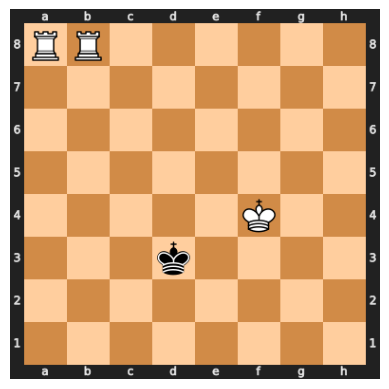

AI is thinking...
AI moved f4g4
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
. . . k . . . .
. . . . . . . .
. . . . . . . .


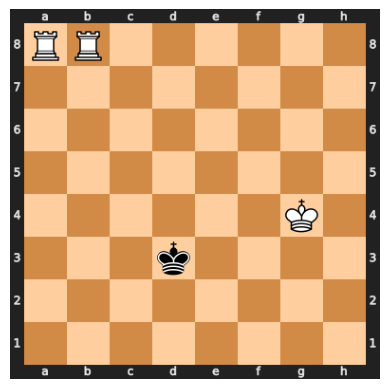

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . k . K .
. . . . . . . .
. . . . . . . .
. . . . . . . .


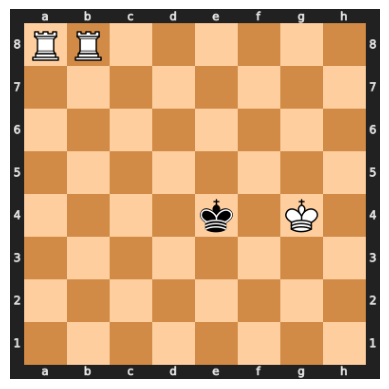

AI is thinking...
AI moved g4g3
R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . k . . .
. . . . . . K .
. . . . . . . .
. . . . . . . .


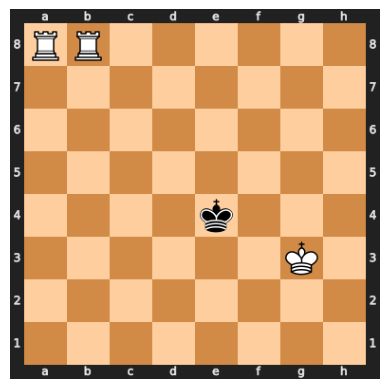

R R . . . . . .
. . . . . . . .
. . . . . . . .
. . . . k . . .
. . . . . . . .
. . . . . . K .
. . . . . . . .
. . . . . . . .


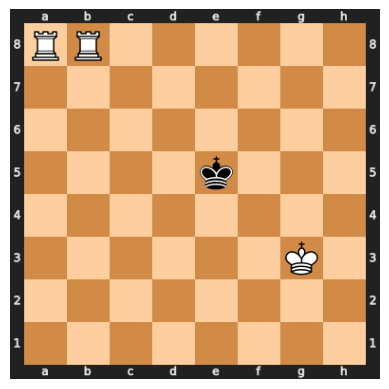

AI is thinking...


In [ ]:


alphaChess = AlphaChess()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


args = {
    'num_searches': 100,
    'num_iterations': 3,
    'num_selfPlay_iterations': 20,
    'num_epochs': 300,
    'batch_size': 256,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}
#learn_fen = "8/8/8/3K4/2B5/6p1/7k/5R2 w - - 0 1"
learn_fen = "RR6/8/8/3K4/8/5k2/8/8 w - - 0 1"
learn = False
load = True
model = ResNet(AlphaChessHelper.ACTION_SIZE, 10, 64, device=device)
if load or not learn:
    model.load_state_dict(torch.load('model_2_AlphaChess.pt', map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

if learn:
    alphaZero = AlphaZero(model, optimizer, alphaChess, args)
    alphaZero.learn(learn_fen)
    engine.quit()

if not learn:
    alphaChess.reset(learn_fen)

    mcts = MCTS(alphaChess, args, model)

    state = alphaChess.get_initial_state()
    player = 1

    while True:
        
        if player == -1:
            if False:
                valid_moves = AlphaChessHelper.get_valid_moves(alphaChess.board)
                # print first 10 valid moves
                print("valid_moves", [AlphaChessHelper.integer_to_move(move) for move in valid_moves][:10])
                action = chess.Move.from_uci(str(input(f"{player}:")))

                if AlphaChessHelper.move_to_integer(action) not in valid_moves:
                    print("action not valid")
                    continue
            else:
                action = AlphaChessHelper.stockfish_play(alphaChess.board)
            player = 1
            
        else:
            print("AI is thinking...")
            neutral_state = AlphaChessHelper.get_encoded_state(alphaChess.board)
            mcts_probs = mcts.search(neutral_state, 1)
            action = AlphaChessHelper.integer_to_move(np.argmax(mcts_probs))
            print("AI moved", action)
            player = -1
        alphaChess.move(action)
        value, is_terminal = AlphaChessHelper.get_value_and_terminated(alphaChess.board, action)
        if is_terminal:
            if value == 1:
                print(player, "won")
            else:
                print("draw")
            break
        print(alphaChess.board)
        display_board(alphaChess.board)
            
